In [1]:
from itertools import islice
import pandas as pd
import numpy as np
from scipy import stats
from  qgrid import show_grid as show 
import plotly.express as px
import math
import seaborn as sns
from matplotlib import pyplot as plt 
import matplotlib as mpl
from matplotlib.lines import Line2D 
from matplotlib.patches import Patch
from itertools import cycle
# pd.options.plotting.backend = "plotly"
pd.options.plotting.backend ='matplotlib'


# mpl.rcParams['boxplot.boxprops.color'] ='red'

# mpl.rcParams['boxplot.boxprops.linewidth']=2
# mpl.rcParams['patch.edgecolor']='black'

# mpl.rcParams['boxplot.patchartist']= "True"
# mpl.rcParams['boxplot.flierprops.marker'] = 'o'
# mpl.rcParams['boxplot.flierprops.color'] = 'k'
# mpl.rcParams['boxplot.flierprops.markerfacecolor'] = "white"
# mpl.rcParams['boxplot.medianprops.color'] = 'red'
#### axes 
mpl.rcParams['axes.titlesize'] = 30 
mpl.rcParams['axes.titlepad'] = 22 
mpl.rcParams['axes.labelsize']=30
mpl.rcParams['axes.labelpad']=20
mpl.rcParams['xtick.labelsize']= 25
mpl.rcParams['ytick.labelsize']= 25
mpl.rcParams['axes.grid']= True

# labelpad
# mpl.rc('axes',titlesize= 30)

# mpl.rc('xtick', labelsize=22) 
# mpl.rc('ytick', labelsize=22) 
mpl.rcParams['text.usetex'] = True

palette=["#D6CADD",
   "#3B0D6E",
    "#3240AB",
    "#0095B6",
    "#72A0C1",
    "#7EECE5",
    "#05B881",
    "#49796B",
    "#E2DC4C",
    "#E0542A",
    "#A83731",
    "#2E3544",
    "#AC2269"
]



In [2]:

def get_recap(x):
    recap=pd.DataFrame()
    mins=x.min()
    maxs=x.max()
    means=x.mean()
    stds=x.std()
    
    mini=x.loc[x["duration"]==mins["duration"]]
    mini["Metric"]="Execution Time"
    recap=recap.append(mini)
    mini=x.loc[x["CPU"]==mins["CPU"]]
    mini["Metric"]="Energy PKG"
    recap=recap.append(mini)
    mini=x.loc[x["DRAM"]==mins["DRAM"]]
    mini["Metric"]="Energy DRAM"
    recap=recap.append(mini)
    recap["Type"]="Best"
    
    maxi=x.loc[x["duration"]==maxs["duration"]]
    maxi["Metric"]="Execution Time"
    maxi["Type"]="Worst"
    recap=recap.append(maxi)
    maxi=x.loc[x["CPU"]==maxs["CPU"]]
    maxi["Metric"]="Energy PKG"
    maxi["Type"]="Worst"
    recap=recap.append(maxi)
    maxi=x.loc[x["DRAM"]==maxs["DRAM"]]
    maxi["Metric"]="Energy DRAM"
    maxi["Type"]="Worst"
    recap=recap.append(maxi)
    recap.reset_index(inplace=True)  
    means["Type"]="Mean"
    stds["Type"]="STD"
    means["Metric"]="All"
    stds["Metric"]="All"
    recap=recap.append(means,ignore_index=True)
    recap=recap.append(stds,ignore_index=True)
    recap=recap.set_index(["Type","Metric"]).loc[:,["duration","CPU","DRAM","jvm","options"]]
    recap["duration"]=recap["duration"]
    recap["CPU"]=recap["CPU"]
    recap["DRAM"]=recap["DRAM"]
    recap.columns=["Execution Time (s)","Energy CPU (J)","Energy DRAM(J)", "JVM","Execution Flags"]
    recap=recap.fillna('')
    return recap

def highlight_max(s):
    is_max = np.logical_and(s == s[:-1].max()  ,s.apply(lambda x:type(x) is float))
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):

    is_min =np.logical_and(s == s[:-1].min()  ,s.apply(lambda x:type(x) is float)) 
    return ['color: green' if v else '' for v in is_min]



def read_data(path):
    data=pd.read_csv(path,sep=";",dtype={"jvm":str,"options":str,"iteration":"Int64","exitcode":"Int64"
                                     ,"duration":"Float64",
                                     "DRAM":"Float64","CPU":"Float64"})
    data=data.loc[data["exitcode"]==0]
    data["duration"]=data["duration"]/1000000
    data["DRAM"]=data["DRAM"]/1000000
    data["CPU"]=data["CPU"]/1000000
    data["distribution"]=data["jvm"].apply(get_distribution)
    data["version"]=data["jvm"].apply(get_version)
    data=data.dropna()
    return data


In [3]:

def plot_energy_cpu(df,benchmark,machine="",save=False):
    title=f"Energy consumption of the benchmark {benchmark} within different JVMs"
    fig, axes = plt.subplots(1, 1, figsize=(32, 14))

    fig=df.loc[df["benchmark"]==benchmark].boxplot(by="jvm",column="energy_pkg",ax=axes,rot=-90,return_type="both",showfliers=False)

    fig[0].ax.set_ylabel(ylabel="Energy Consumption (J)",labelpad=22,fontsize="30")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    ########## legends 
    legends=[Line2D([0], [0], marker='o', color='k', label='J9',
                          markerfacecolor='#3498DB', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='GraalVM',
                          markerfacecolor='#16A085', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='OpenJDK',
                          markerfacecolor='#F0B27A', markersize=30),
            Line2D([0], [0], marker='o', color='k', label='Others',
                          markerfacecolor='w', markersize=30)
            ]
    
    fig[0].ax.legend(handles=legends, loc='lower left',fontsize='xx-large',labelspacing=1)
    
    ############## inside the boxplots 
    for i in range(len(fig[0][1]['boxes'])): 
        color = get_filling_color(fig[0][0].get_xticklabels()[i].get_text())
        fig[0][1]['boxes'][i].set(color="b",edgecolor='black',facecolor=color,linewidth=1)
        fig[0][1]['medians'][i].set(color="red",linewidth=0.5)
        fig[0][1]['whiskers'][i].set(color="black",linewidth=1)
    
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if save :
        fig[0].ax.set_title("",fontsize="30",pad=50  )
        plt.savefig(f"energy_pkg_all_{benchmark}{machine}.pdf",format="pdf")
    else:
        fig[0].ax.set_title(title,fontsize="30",pad=50  )
        plt.show()
    return fig

def plot_execution_time(df,benchmark,machine="",save=False):
    title=f"Excution time of the benchmark {benchmark} within different JVMs"
    fig, axes = plt.subplots(1, 1, figsize=(32, 12))
#     plt.subplots_adjust(wspace=0.25,top=4,left = 0,right = 1)
    fig=df.loc[df["benchmark"]==benchmark].boxplot(by="jvm",column="execution_time",ax=axes,rot=-90,return_type="both",showfliers=False)

    
    fig[0].ax.set_ylabel(ylabel="Execution time (s)",labelpad=22,fontsize="30")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    
    legends=[Line2D([0], [0], marker='o', color='k', label='J9',
                          markerfacecolor='#3498DB', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='GraalVM',
                          markerfacecolor='#16A085', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='OpenJDK',
                          markerfacecolor='#F0B27A', markersize=30),
            Line2D([0], [0], marker='o', color='k', label='Others',
                          markerfacecolor='w', markersize=30)
            
            ]
    
    fig[0].ax.legend(handles=legends, loc='lower left',fontsize='xx-large',labelspacing=1)
    
    for i in range(len(fig[0][1]['boxes'])): 
        color = get_filling_color(fig[0][0].get_xticklabels()[i].get_text())
        fig[0][1]['boxes'][i].set(color="b",edgecolor='black',facecolor=color,linewidth=1)
        fig[0][1]['medians'][i].set(color="red",linewidth=0.5)
        fig[0][1]['whiskers'][i].set(color="black",linewidth=1)
    if save :
        fig[0].ax.set_title("",fontsize="30",pad=50  )
        plt.savefig(f"execution_time_all_{benchmark}{machine}.pdf",format="pdf")
    else:
        fig[0].ax.set_title(title,fontsize="30",pad=50  )
        plt.show()
    return fig


def plot_energy_dram(df,benchmark,machine="",save=False):
    title=f"DRAM Energy consumption of the benchmark {benchmark} within different JVMs"
    fig, axes = plt.subplots(1, 1, figsize=(32, 12))
    plt.tight_layout()
    
    fig=df.loc[df["benchmark"]==benchmark].boxplot(by="jvm",column="energy_dram",ax=axes,rot=-90,return_type="both",showfliers=False)


    
    fig[0].ax.set_ylabel(ylabel="Energy Consumption (J)",labelpad=22,fontsize="30")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    ########## legends 
    legends=[Line2D([0], [0], marker='o', color='k', label='J9',
                          markerfacecolor='#3498DB', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='GraalVM',
                          markerfacecolor='#16A085', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='OpenJDK',
                          markerfacecolor='#F0B27A', markersize=30),
            Line2D([0], [0], marker='o', color='k', label='Others',
                          markerfacecolor='w', markersize=30)
            ]
    
    fig[0].ax.legend(handles=legends, loc='upper left',fontsize='xx-large',labelspacing=1)
    
    ############## inside the boxplots 
    for i in range(len(fig[0][1]['boxes'])): 
        color = get_filling_color(fig[0][0].get_xticklabels()[i].get_text())
        fig[0][1]['boxes'][i].set(color="b",edgecolor='black',facecolor=color,linewidth=1)
        fig[0][1]['medians'][i].set(color="red",linewidth=0.5)
        fig[0][1]['whiskers'][i].set(color="black",linewidth=1)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if save :
        fig[0].ax.set_title("",fontsize="30",pad=50  )
        plt.savefig(f"energy_dram_all_{benchmark}{machine}.pdf",format="pdf")
    else:
        fig[0].ax.set_title(title,fontsize="30",pad=50  )
        plt.show()
    return fig


def plot_power_cpu(df,benchmark,machine="",save=False):
    title=f"Average power  the benchmark {benchmark} within different JVMs"
    fig, axes = plt.subplots(1, 1, figsize=(32, 12))
    fig=df.loc[df["benchmark"]==benchmark].boxplot(by="jvm",column="av_power_cpu",ax=axes,rot=-90,return_type="both",showfliers=False)


    
    fig[0].ax.set_ylabel(ylabel="Average Power Consumption (W)",labelpad=22,fontsize="30")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    ########## legends 
    legends=[Line2D([0], [0], marker='o', color='k', label='J9',
                          markerfacecolor='#3498DB', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='GraalVM',
                          markerfacecolor='#16A085', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='OpenJDK',
                          markerfacecolor='#F0B27A', markersize=30),
            Line2D([0], [0], marker='o', color='k', label='Others',
                          markerfacecolor='w', markersize=30)
            ]
    
    fig[0].ax.legend(handles=legends, loc='upper left',fontsize='xx-large',labelspacing=1)
    
    ############## inside the boxplots 
    for i in range(len(fig[0][1]['boxes'])): 
        color = get_filling_color(fig[0][0].get_xticklabels()[i].get_text())
        fig[0][1]['boxes'][i].set(color="b",edgecolor='black',facecolor=color,linewidth=1)
        fig[0][1]['medians'][i].set(color="red",linewidth=0.5)
        fig[0][1]['whiskers'][i].set(color="black",linewidth=1)
    if save :
        fig[0].ax.set_title("",fontsize="30",pad=50  )
        plt.savefig(f"power_pkg_all_{benchmark}{machine}.pdf",format="pdf")
    else:
        fig[0].ax.set_title(title,fontsize="30",pad=50  )
        plt.show()
    return fig



In [64]:
#BOX Plots 

def boxplot_cpu(df,benchmark,axes):
    
    title=f"Energy consumption of CPU for the benchmark {benchmark} within different JVMs"
    fig =plot_box(df,"CPU",axes)
    fig[0].ax.set_ylabel(ylabel="Energy Consumption (J)")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    fig[0].ax.set_title(title  )
    
def boxplot_dram(df,benchmark,axes):
    
    title=f"Energy consumption of DRAM for the benchmark  {benchmark} within different JVMs"
    fig =plot_box(df,"DRAM",axes)
    fig[0].ax.set_ylabel(ylabel="Energy Consumption (J)")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    fig[0].ax.set_title(title  )
    
def boxplot_duration(df,benchmark,axes):
    title=f"Excution time of the benchmark {benchmark} within different JVMs"
    fig =plot_box(df,"duration",axes)
    fig[0].ax.set_ylabel(ylabel="Execution Time (s)")
    fig[0].ax.get_figure().suptitle('')
    fig[0].ax.set_xlabel(xlabel='')
    fig[0].ax.set_title(title  )
    
def plot_box(df,metric,axes):
    colors=dict(zip(df["distribution"].unique(),cycle(palette)))
    legends=[Patch(facecolor=color, label=distribution) for distribution,color in colors.items()]
    
    fig=df.boxplot(by="name",column=metric,ax=axes,rot=-90,return_type="both",showfliers=False,backend='matplotlib')
   ############# inside the boxplots 
    
    for i in range(len(fig[0][1]['boxes'])): 
        jvm=fig[0][0].get_xticklabels()[i].get_text().split(" ")[1]
        distribution=get_distribution(jvm)
        color = colors[distribution]
        fig[0][1]['boxes'][i].set(color=color,linewidth=2)
        fig[0][1]['medians'][i].set(color="red",linewidth=1)
    for i in range(len(fig[0][1]['whiskers'])): 
        fig[0][1]['whiskers'][i].set(color=color,linewidth=1)
        fig[0][1]['caps'][i].set(color=color,linewidth=1) 
    axes.legend(handles=legends,fontsize=25,loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    axes.set_xticklabels([ x.get_text().split(' ')[1] for x in axes.get_xticklabels()])
    return fig


In [26]:
df.distribution.unique()

array(['albba', 'amzn', 'grl-19', 'grl-20', 'hs-adpt', 'j9-adpt',
       'librca', 'mandrel', 'open', 'sapmchn', 'trava', 'zulu'],
      dtype=object)

In [69]:
#BarPlot


def plot_stacked_bar(full_data,metric,base,axes):
    full_data=data.sort_values(["name","benchmark"]).reset_index()
    benchmarks=full_data["benchmark"].unique()
    l2={bench:full_data.loc[full_data["benchmark"]==bench]for bench in benchmarks}
    jvms=full_data["name"].unique()
    means={bench:df.groupby(["name"]).mean()[metric]  for bench,df in l2.items() }
    means=[df/base.loc[bench,metric]*100 / len(benchmarks) for  bench,df in means.items()]
    for i in range(len(benchmarks)) :
        axes.bar(jvms,means[i],bottom=sum(means[:i]),color=palette[i],label=benchmarks[i])
   
    axes.legend(fontsize=25,loc='center left', bbox_to_anchor=(1.0, 0.5))
    axes.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    axes.tick_params(axis='x', labelrotation = -90)
#     axes.set_xticks([ x.get_text().split(' ')[1] for x in axes.get_xticklabels()])
    
    return axes


def plot_stacked_cpu(full_data,basename,base,axes):
    title=f"Relative Energy consumption of CPU for all benchmarks based on {basename}"
    axes=plot_stacked_bar(full_data,"CPU",base,axes)
    axes.set_ylabel(ylabel="Energy Consumption ratio (\%)")
    axes.set_xlabel(xlabel="JVM Distribution")
    axes.set_title(title)
    return axes

def plot_stacked_dram(full_data,basename,base,axes):
    title=f"Relative Energy consumption of DRAM for all benchmarks based on {basename}"
    axes=plot_stacked_bar(full_data,"DRAM",base,axes)
    axes.set_ylabel(ylabel="Energy Consumption ratio (\%)")
    axes.set_xlabel(xlabel="JVM Distribution")
    axes.set_title(title)
    return axes
def plot_stacked_duration(full_data,basename,base,axes):
    title=f"Relative Execution time for all benchmarks based on {basename}"
    axes=plot_stacked_bar(full_data,"DRAM",base,axes)
    axes.set_ylabel(ylabel="Execution Time ratio (\%)")
    axes.set_xlabel(xlabel="JVM Distribution")
    axes.set_title(title)
    return axes

In [6]:
jvm_labels={
'open' : 'HotSpot' ,
'zulu' : 'Zulu' ,
'albba' : 'Dragonwell (LTS)' ,
'amzn' : 'Corretto (MJR)' ,
'librca' : 'Librca' ,
'sapmchn' : 'SapMachine' ,
'trava' : 'HotSpotTrava (LTS)' ,
'hs-adpt' : 'HotSpotAdopt' ,
'j9-adpt' : 'J9' ,
'grl-19' : 'GraalVM-19 (LTS)' ,
'mandrel' : 'Mandrel' ,
'grl-20' : 'GraalVM-20 (LTS)',
    }

def get_distribution(jvm):
    s=jvm.split("-")[-1]
    if s == "grl":
        version=jvm.split(".")[0]
        s=f"grl-{version}"
    elif s == "adpt" : 
        s=jvm.split(".")[-1]

    return s

def get_version(jvm):
    s=jvm.split("-")[-1]
    jvm=jvm.split("-")[0]
    if s == "grl" :
        s=jvm.split(".")[-1].replace("r","")
    elif s =="albba" : 
        s=jvm.split(".")[0].split("u")[0]
    elif s =="mandrel" :
        s=11
    else :
        s = jvm.split(".")[0]
    try : 
        s= int(s)
    except : 
        s= 0
    return s

def plot_lineplots_global(data,metric,base,axes):
    full_data=data.sort_values(["jvm","benchmark"])
    benchmarks=full_data["benchmark"].unique()
    l2={bench:full_data.loc[full_data["benchmark"]==bench]for bench in benchmarks}
    jvms=full_data["jvm"].unique()
    means={bench:df.groupby(["jvm"]).mean()[metric]  for bench,df in l2.items() }
    means=[df/base.loc[bench,metric]*100 / len(benchmarks) for  bench,df in means.items()]
    full_data=pd.concat(means).reset_index()
    full_data["version"]=full_data["jvm"].apply(get_version)
    full_data["distribution"]=full_data["jvm"].apply(get_distribution)
    full_data=full_data.groupby(["jvm","version","distribution"])[metric].sum().reset_index()
    full_data=full_data.sort_values("version")   
    for i in full_data["distribution"].unique() : 
        x= full_data.loc[full_data["distribution"]==i]      
        axes.plot(x["version"],x[metric])
        axes.scatter(x["version"],x[metric],s=100,label=jvm_labels[i]) 
    axes.legend(fontsize=25,loc='center left', bbox_to_anchor=(1.0, 0.5))
    axes.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    axes.set_xlabel(xlabel="Java version ")
    return axes

def plot_lineplots_global_cpu(full_data,basename, base,axes,benchname=""):
    title=f"The evolution of average Energy consumption of CPU through different java versions based on {basename} {benchname}"
    axes=plot_lineplots_global(full_data,"CPU",base,axes)
    axes.set_ylabel(ylabel="Energy Consumption ratio (\%)")
    axes.set_xlabel(xlabel="JVM Distribution")
    axes.set_title(title)
    return axes

def plot_lineplots_global_dram(full_data,basename,base,axes,benchname=""):
    title=f"The evolution of average Energy consumption of DRAM through different java versions based on {basename} {benchname}"
    axes=plot_lineplots_global(full_data,"DRAM",base,axes)
    axes.set_ylabel(ylabel="Energy Consumption ratio (\%)")
    axes.set_xlabel(xlabel="JVM Distribution")
    axes.set_title(title)
    return axes

def plot_lineplots_global_duration(full_data,basename,base,axes,benchname=""):
    title=f"The evolution of average Execution time through different java versions based on {basename} {benchname} "
    axes=plot_lineplots_global(full_data,"duration",base,axes)
    axes.set_ylabel(ylabel="Execution Time ratio (\%)")
    axes.set_xlabel(xlabel="JVM Distribution")
    axes.set_title(title)
    return axes



In [7]:
def plot_evolution(data2,metric,axes):
    base=data2.loc[data2["version"]==min(data2["version"])]
    base=base.groupby("benchmark").mean()
    data2=data2.groupby(["version","benchmark"])[metric].mean().reset_index()
    data2=data2.sort_values(["version","benchmark"])
    for i in data2["benchmark"].unique() : 
        x= data2.loc[data2["benchmark"]==i]
        x["relative_metric"]=x[metric]/base.loc[i,metric]*100
        axes.plot(x["version"],x["relative_metric"])
        axes.scatter(x["version"],x["relative_metric"],s=100,label=i)
    
    axes.legend(fontsize=25,loc='center left', bbox_to_anchor=(1.0, 0.5),)
    axes.set_xlabel(xlabel="Java version ")
    axes.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    return axes 
    

def plot_evolution_cpu(full_data,axes):
    title=f"The evolution of average Energy consumption of CPU through different  java versions "
    axes=plot_evolution(full_data,"CPU",axes)
    axes.set_ylabel(ylabel="Energy Consumption ratio (\%)")
    axes.set_title(title)
    return axes

def plot_evolution_dram(full_data,axes):
    title=f"The evolution of average Energy consumption of DRAM through different java versions "
    axes=plot_evolution(full_data,"DRAM",axes)
    axes.set_ylabel(ylabel="Energy Consumption ratio (\%)")
    axes.set_title(title)
    return axes

def plot_evolution_duration(full_data,axes):
    title=f"The evolution of average Execution time through different java versions "
    axes=plot_evolution(full_data,"duration",axes)
    axes.set_ylabel(ylabel="Execution Time ratio (\%)")
    axes.set_title(title)
    return axes


In [8]:
def bar_plot_energy(df,save=False):
    title=f"Energy consumption within different JVMs"
    fig, axes = plt.subplots(1, 1, figsize=(32, 12))
    y=df.pivot(columns="jvm",index='benchmark', values='CPU')
    y=y.loc[:,["20.2.0.r11-grl","15.0.1.j9-adpt","15.0.1-open","8.0.265-open"]]

   
    y["20.2.0.r11-grl"]=y.apply(lambda row : row["20.2.0.r11-grl"]/row["8.0.265-open"]*100,axis=1)
    y["15.0.1.j9-adpt"]=y.apply(lambda row : row["15.0.1.j9-adpt"]/row["8.0.265-open"]*100,axis=1)
    y["15.0.1-open"]=y.apply(lambda row : row["15.0.1-open"]/row["8.0.265-open"]*100,axis=1)
    y["8.0.265-open"]=y.apply(lambda row : row["8.0.265-open"]/row["8.0.265-open"]*100,axis=1)
    
    fig= y.plot.bar(align='center' ,rot=0,ax=axes,color={"15.0.1.j9-adpt":"#3498DB","20.2.0.r11-grl":"#16A085","15.0.1-open":"#F0B27A","8.0.265-open":"#ea5f5b"},grid=True)
    
    fig.set_ylabel(ylabel="Energy Consumption ratio (\%)")
    fig.get_figure().suptitle('')
    fig.set_xlabel(xlabel='')
    fig.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    ########## legends 
    
    legends=[
        Line2D([0], [0], marker='o', color='k', label='GraalVM',
                          markerfacecolor='#16A085', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='J9',
                          markerfacecolor='#3498DB', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='HotSpot-8',
                          markerfacecolor='#ea5f5b', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='HotSpot-15',
                          markerfacecolor='#F0B27A', markersize=30),
              
#             Line2D([0], [0], marker='o', color='k', label='Others',
#                           markerfacecolor='w', markersize=30)
            ]
    
    fig.legend(handles=legends, loc='upper left',fontsize='25',labelspacing=1)
    
    plt.xlim([-0.5, 11.65])
    
    plt.tight_layout()
    if save :
        fig.set_title("",fontsize="30",pad=50  )
        plt.savefig(f"bar_plot_all_basedon8.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
    else:
        fig.set_title(title,fontsize="30",pad=50  )
        plt.show()
    return fig

In [50]:
data=read_data("alldata_dacapo_renaissance.csv")
targetdir="results_all_data/dacapo_renaissance"
# data=read_data("data_gc.csv")
# data=read_data("data_jit.csv")
# data=read_data("jvm-recommender/zip4j_1_chetemi_14.csv")

data["name"]=data.apply(lambda row : f"{(row['distribution'])} {row['jvm']}",axis=1)
data.sort_values(["distribution","jvm"], inplace=True)
basename="8.0.265-open"
base=data.loc[data["jvm"]==basename]
base=base.groupby("benchmark").mean()

IndexError: list index out of range

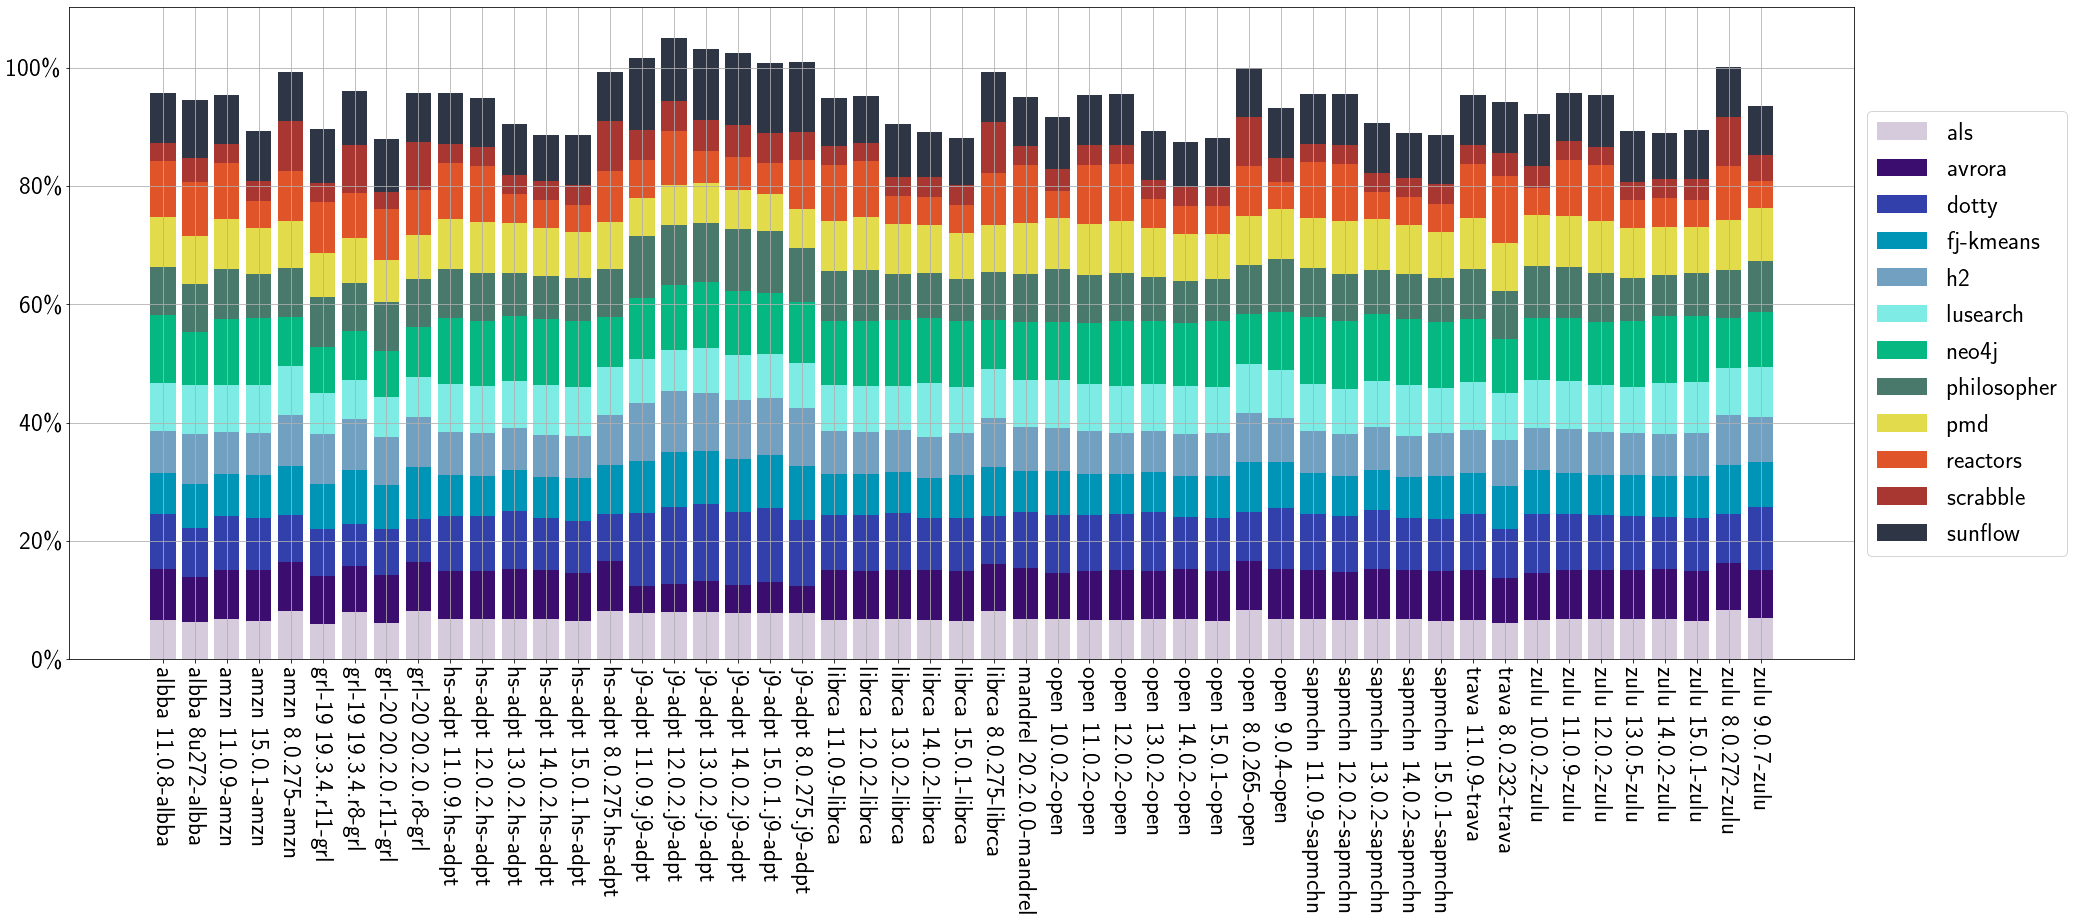

In [51]:

fig, axes = plt.subplots(1, 1, figsize=(32, 12))
fig=plot_stacked_cpu(data,basename,base,axes)
plt.savefig(f"{targetdir}/bar_all_cpu_basedon_8.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
fig, axes = plt.subplots(1, 1, figsize=(32, 12))
fig=plot_stacked_dram(data,basename,base,axes)
plt.savefig(f"{targetdir}/bar_all_dram_basedon_8.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
fig, axes = plt.subplots(1, 1, figsize=(32, 12))
fig=plot_stacked_duration(data,basename,base,axes)
plt.savefig(f"{targetdir}/bar_all_duration_basedon_8.pdf",format="pdf",bbox_inches='tight',pad_inches=0)


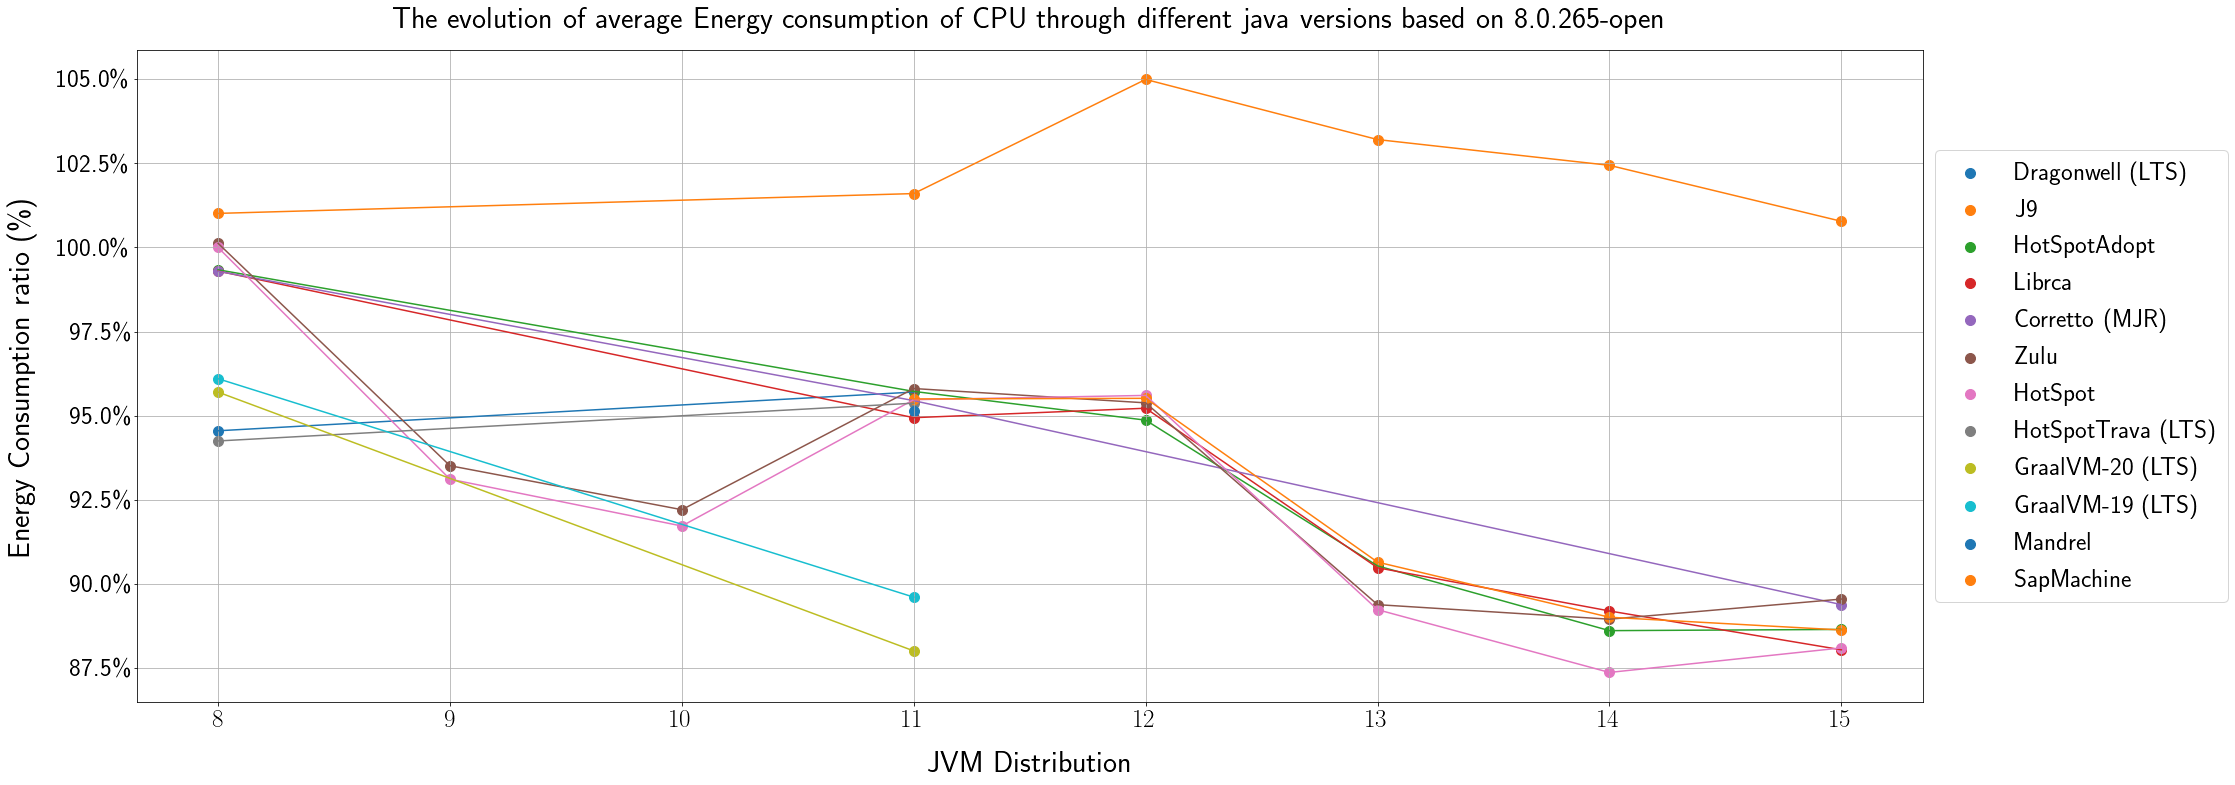

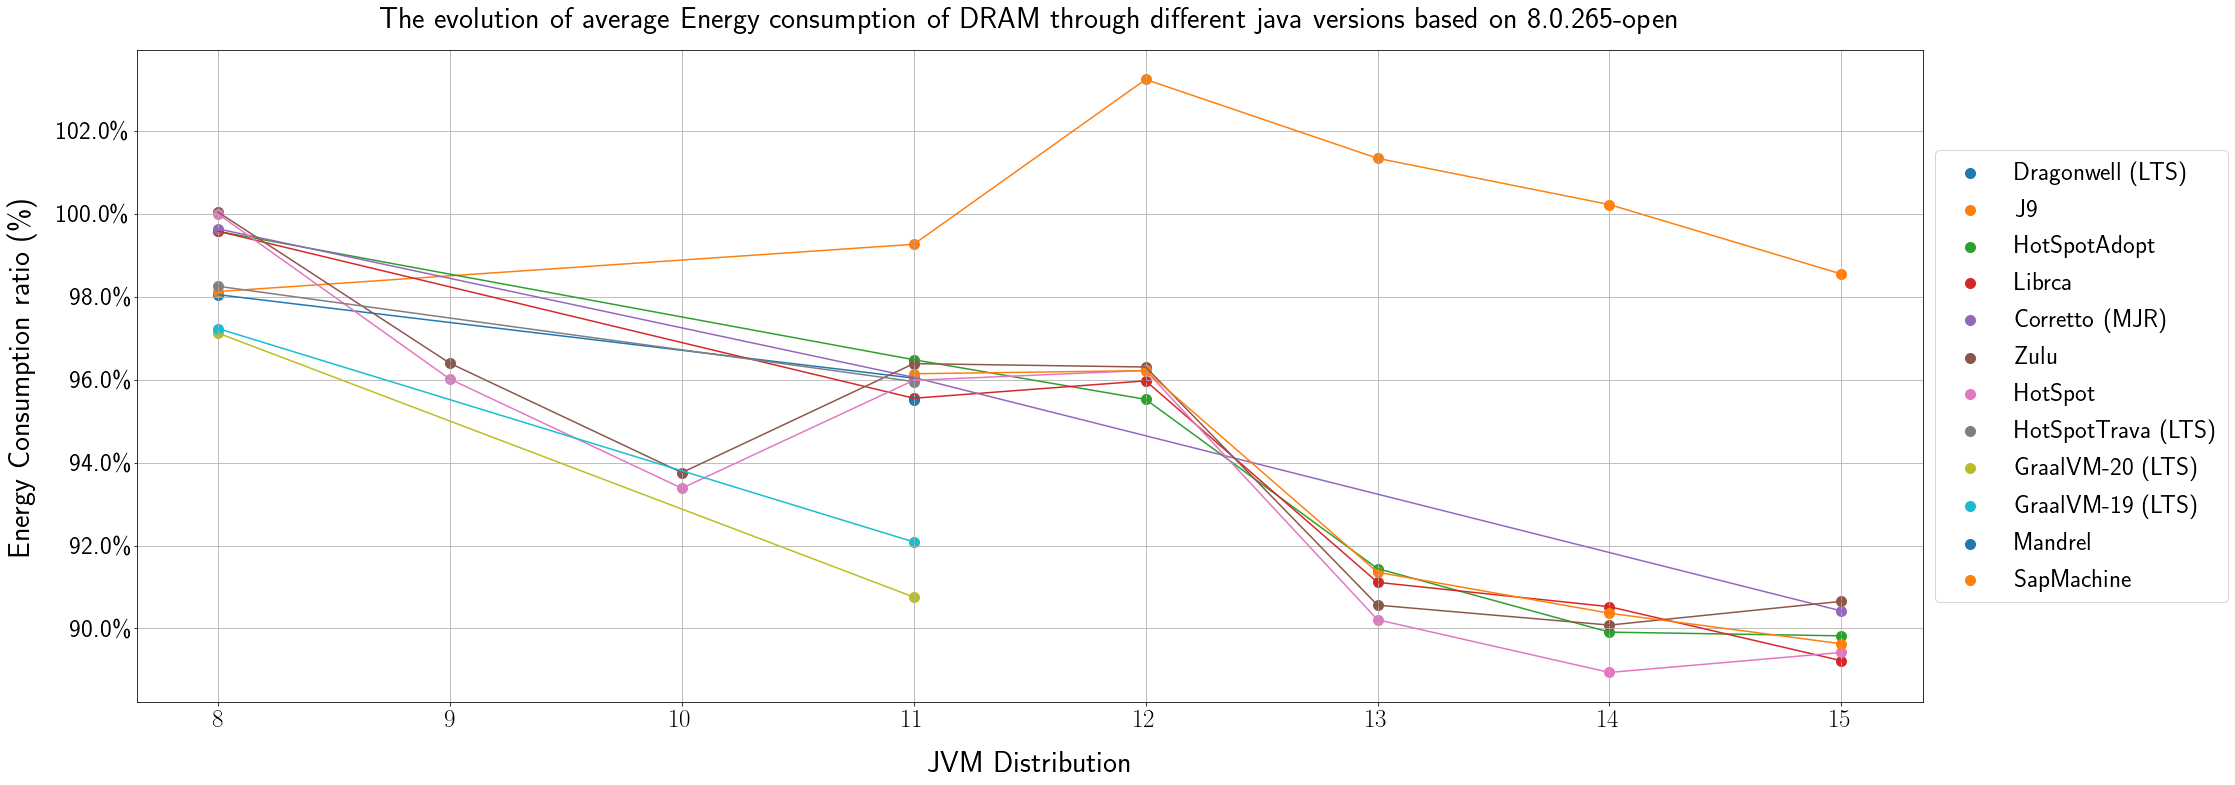

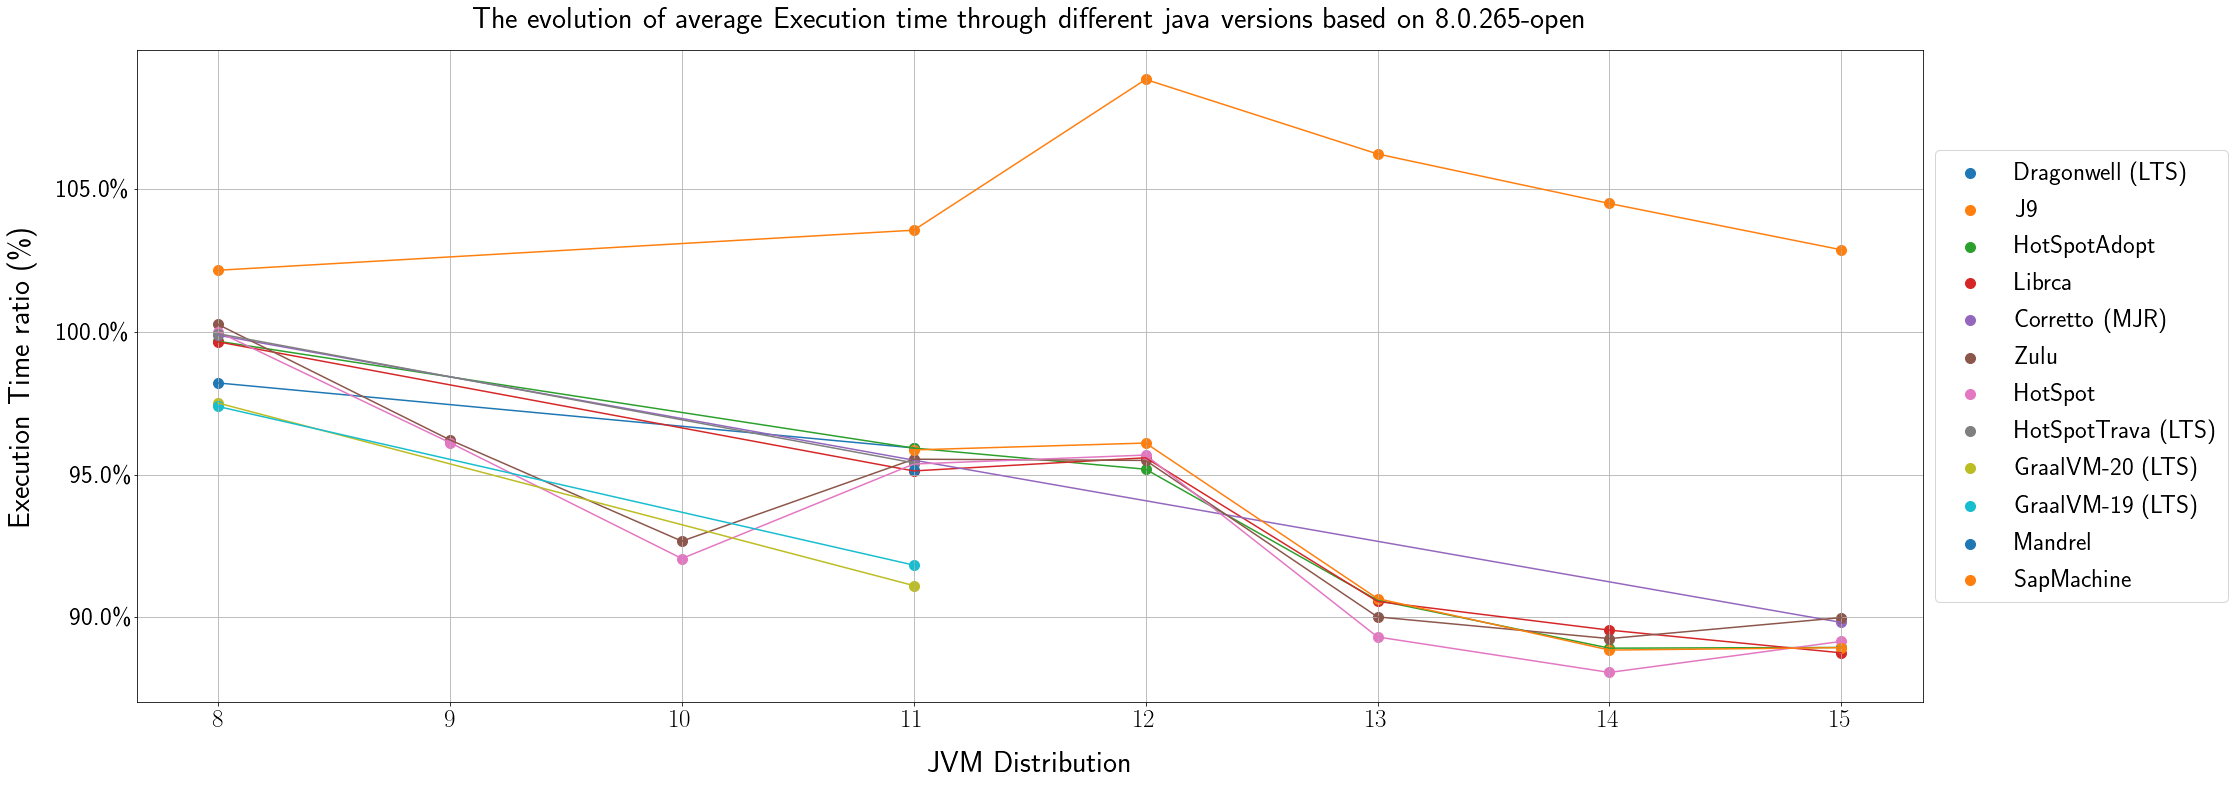

In [74]:
# fig, axes = plt.subplots(1, 1, figsize=(32, 12))
# fig=plot_lineplots_global_cpu(data,basename,base,axes)
# plt.savefig(f"{targetdir}/global_evolution_cpu_basedon_8.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
# fig, axes = plt.subplots(1, 1, figsize=(32, 12))
# fig=plot_lineplots_global_dram(data,basename,base,axes)
# plt.savefig(f"{targetdir}/global_evolution_dram_basedon_8.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
# fig, axes = plt.subplots(1, 1, figsize=(32, 12))
# fig=plot_lineplots_global_duration(data,basename,base,axes)
# plt.savefig(f"{targetdir}/global_evolution_duration_basedon_8.pdf",format="pdf",bbox_inches='tight',pad_inches=0)


In [12]:
# benchmarks=data.benchmark.unique()
# for bench in benchmarks: 
#     df=data.loc[data["benchmark"]==bench]
#     fig, axes = plt.subplots(1, 1, figsize=(32, 12))
#     _=plot_lineplots_global_cpu(df,basename,base,axes,f"for {bench}")
#     plt.savefig(f"{targetdir}/evolution_cpu_basedon_8_{bench}.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
#     plt.close(fig)
#     fig, axes = plt.subplots(1, 1, figsize=(32, 12))
#     _=plot_lineplots_global_dram(df,basename,base,axes,f"for {bench}")
#     plt.savefig(f"{targetdir}/evolution_dram_basedon_8_{bench}.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
#     plt.close(fig)
#     fig, axes = plt.subplots(1, 1, figsize=(32, 12))
#     _=plot_lineplots_global_duration(df,basename,base,axes,f"for {bench}")
#     plt.savefig(f"{targetdir}/evolution_duration_basedon_8_{bench}.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
#     plt.close(fig)

In [14]:
# distributions=data["distribution"].unique()
# for dist in distributions: 
#     df=data.loc[data["distribution"]==dist]
#     fig, axes = plt.subplots(1, 1, figsize=(32, 12))
#     _=plot_evolution_cpu(df,axes)
#     plt.savefig(f"{targetdir}/evolution_cpu_{dist}.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
#     plt.close(fig)
#     fig, axes = plt.subplots(1, 1, figsize=(32, 12))
#     _=plot_evolution_dram(df,axes)
#     plt.savefig(f"{targetdir}/evolution_dram_{dist}.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
#     plt.close(fig)
#     fig, axes = plt.subplots(1, 1, figsize=(32, 12))
#     _=plot_evolution_duration(df,axes)
#     plt.savefig(f"{targetdir}/evolution_duration_{dist}.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
#     plt.close(fig)



<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["relative_metric"]=x[metric]/base.loc[i,metric]*100
<ipython-input-7-f88052f325c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
benchmarks=data.benchmark.unique()

for bench in benchmarks: 
    df=data.loc[data["benchmark"]==bench]
    fig, axes = plt.subplots(1, 1, figsize=(32, 12))
    _=boxplot_cpu(df,bench,axes)
    plt.savefig(f"{targetdir}/boxplot_cpu_{bench}.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
    plt.close(fig)
    fig, axes = plt.subplots(1, 1, figsize=(32, 12))
    _=boxplot_dram(df,bench,axes)
    plt.savefig(f"{targetdir}/boxplot_dram_{bench}.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
    plt.close(fig)
    fig, axes = plt.subplots(1, 1, figsize=(32, 12))
    _=boxplot_duration(df,bench,axes)
    plt.savefig(f"{targetdir}/boxplot_duration_{bench}.pdf",format="pdf",bbox_inches='tight',pad_inches=0)
    plt.close(fig)